# 调包与参数

In [ ]:
from typing import List
from SetRNN import *
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence, pad_packed_sequence
from collections import Counter # 用于统计计数的工具
import time # 用于计时
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils # 用于处理变长序列，如填充和打包
from torch.utils.data import Dataset, DataLoader # PyTorch 数据加载工具
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm # 进度条库，使用 tqdm.tqdm
import random
import pyreadstat
import copy # 用于复制模型参数或列表
import matplotlib.pyplot as plt # 用于绘图
import seaborn as sns # 用于更美观的统计图，特别是热力图
import pickle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EARLY_ITER_BATCH_THRESHOLD = 3 # 在前 3 轮迭代中使用部分批次 (适应总迭代 10)
EARLY_ITER_BATCH_PERCENT = 0.3
#损失函数缩放因子
#为了让再分类保持time+setting,而prune只用setting，需要设置不同的缩放因子
SETTING_SCALER = 1.0
SETTING_SCALER_RECLASSIFY = 1.0
TIME_SCALER_PRUNE = 0
TIME_SCALER_RECLASSIFY = 1.0
# 超参数和常量定义
NUM_MAIN_MODELS = 3 # 主要的聚类模型数量
NUM_COMBINED_SETTINGS = 23 # combined_setting 的总类别数 (0-124)
EMBEDDING_DIM = 8 # combined_setting 的嵌入向量维度，可调整
HIDDEN_SIZE = 64   # RNN 隐藏层大小，可调整
NUM_RNN_LAYERS = 2 # RNN 层数
# 注意: TIME_LOSS_SCALER 可能需要根据实际 delta_t 的规模重新调整
TOTAL_EM_ITERATIONS = 10 # EM 迭代总次数 (根据要求修改为 10)
CONVERGENCE_THRESHOLD = 0.05 # 收敛阈值，分配改变的序列比例低于此值时停止 (5%)

# 干扰项处理参数
NUM_RAND_SEQUENCES = 250 # 干扰项的已知数量
INTERFERENCE_CLUSTER_LABEL = 3 # 将干扰项分配到的簇的索引 (0, 1, 2 是主簇，3 是干扰簇)
INTERFERENCE_DETECTION_START_ITER = 2 # 从第 5 轮迭代 (索引 4) 的 E 步开始检测干扰项
# 检测干扰项的高损失阈值：需要根据训练中观察到的损失值范围来调整
# 如果一个序列在所有模型上的平均损失超过这个阈值，则可能被认为是干扰项。
# ！！！重要参数，需要根据实际运行观察的损失值调整！！！
# 在模拟数据上运行一次，观察损失值的分布，尤其是 rand_label 序列的损失。
HIGH_AVG_LOSS_THRESHOLD = 0.5 ## <--- !!! 初始值，请务必根据实际情况调整 !!!

# M 步训练参数 (每个 EM 迭代中的训练 epochs)
# epochs 计划表：根据迭代次数使用不同数量的 epochs
EPOCH_SCHEDULE = [1] * 5 + [2]* 5 # 示例：前 3 轮迭代训练 2 epoch，接下来 7 轮训练 5 epoch (适应总迭代 10)
BATCH_SIZE = 32 # M 步训练时的批次大小
# 在早期迭代中是否只使用部分批次来加速训练
EARLY_ITER_BATCH_THRESHOLD = 3 # 在前 3 轮迭代中使用部分批次 (适应总迭代 10)
EARLY_ITER_BATCH_PERCENT = 1 # 在启用部分批次训练时使用的批次比例 (30%)

# 函数

In [2]:
def LossCalculate(loaded_list,final_assignment_list,Model,models,setting_scaler,time_scaler):
    '''
    参数
        Loaded_list:载入的数据list,其中元素为数据框与一个字符串,数据框有time和combined_setting两个行,长度不小于3。
        final_assignment_list:在rnn cluster中每个序列分配的模型的索引,长度与loaded_list相同
        Model:一个RNN评估模型,在所有数据上训练得到
        models:一个列表,作为RNN分类模型,元素为rnn cluster过程中产生的RNN模型
    返回
        total_loss_list,setting_loss_list,time_loss_list:双层list,储存每一个序列的每一步的损失值,分别为总和、setting列和time列的损失值。第i个元素的第j个元素即为第i个“output序列”
        的第j个delta_T和第j个setting的损失。
    使用第t步的设置和第t步到第t+1步的时间差作为输入,预测第t+1步的设置和第t+1步到t+2步的时间差
    '''
    #计算每个序列的损失
    setting_loss_list=[None]*len(loaded_list)
    time_loss_list=[None]*len(loaded_list)
    for i in range(len(loaded_list)):
        seq_time=torch.FloatTensor(loaded_list[i][0]["time"].values)
        seq_setting=torch.LongTensor(loaded_list[i][0]["combined_setting"].values)
        time_criterion = nn.MSELoss(reduction= "sum")
        setting_criterion = nn.CrossEntropyLoss(reduction= "sum")
        if final_assignment_list[i] >= len(models):
            setting_loss_list[i] = [0]
            time_loss_list[i] = [0]
            continue
        model = Model

        #deltaT_inputs是时间差的输入，setting_inputs是设置的输入
        #使用第t步的设置和第t步到第t+1步的时间差作为输入，预测第t+1步的设置和第t+1步到t+2步的时间差
        deltaT_inputs=(seq_time[1:-1] - seq_time[:-2]).unsqueeze(0).to(device)
        setting_inputs=seq_setting[0:-2].unsqueeze(0).to(device)

        deltaT_targets=(seq_time[2:] - seq_time[1:-1]).unsqueeze(0).to(device)
        setting_targets=seq_setting[1:-1].unsqueeze(0).to(device)

        input_len = seq_time.shape[0] - 2#输出输出的长度
        length = torch.tensor([input_len])

        #模型预测
        predict_deltaT, predict_setting,_ = model(deltaT_inputs, setting_inputs, length)
        
        #计算损失
        seq_time_loss_tensor=[time_criterion(predict_deltaT.squeeze(0)[i], deltaT_targets.squeeze(0)[i]) for i in range(predict_deltaT.squeeze(0).shape[0])]
        seq_setting_loss_tensor=[setting_criterion(predict_setting.squeeze(0)[i].unsqueeze(0), setting_targets.squeeze(0)[i].unsqueeze(0)) for i in range(predict_setting.squeeze(0).shape[0])]
        
        seq_time_loss_list=[_.item() for _ in seq_time_loss_tensor]
        seq_setting_loss_list=[_.item() for _ in seq_setting_loss_tensor]
        setting_loss_list[i]=seq_setting_loss_list
        time_loss_list[i]=seq_time_loss_list

    #total_loss_list代表每个列表每一步的总损失
    total_loss_list = [[setting_loss_list[i][j]*setting_scaler+ time_loss_list[i][j]*time_scaler for j in range(len(setting_loss_list[i]))]for i in range(len(setting_loss_list)) ]
    return total_loss_list,setting_loss_list,time_loss_list

In [3]:
def ThresholdCalculate_byseq(total_loss_list,setting_loss_list,time_loss_list,threshold):
    '''
    参数:
        total_loss_list,setting_loss_list,time_loss_list:双层list,储存每一个序列的每一步的损失值,分别为总和、setting列和time列的损失值。第i个元素的第j个元素即为第i个“output序列”
        的第j个delta_T和第j个setting的损失。
        threshold:一个百分比值,代表要被删掉的序列的比例
    返回:
        setting_threshold_min,time_threshold_min,total_threshold_min:三个阈值,分别为setting列,time列和总损失的阈值,低于该阈值的比例为threshold;
        setting_threshold_max,time_threshold_max,total_threshold_max:三个阈值,分别为setting列,time列和总损失的阈值,高于该阈值的比例为threshold;
        total_step_length:所有序列总的步骤数
    '''
    setting_threshold_byseq_min,time_threshold_byseq_min,total_threshold_byseq_min=[None]*len(setting_loss_list),[None]*len(time_loss_list),[None]*len(total_loss_list)
    setting_threshold_byseq_max,time_threshold_byseq_max,total_threshold_byseq_max=[None]*len(setting_loss_list),[None]*len(time_loss_list),[None]*len(total_loss_list)

    for i in range(len(total_loss_list)):
        setting_threshold_byseq_min[i] = np.percentile(setting_loss_list[i], threshold)
        time_threshold_byseq_min[i] = np.percentile(time_loss_list[i], threshold)
        total_threshold_byseq_min[i] = np.percentile(total_loss_list[i], threshold)

        setting_threshold_byseq_max[i] = np.percentile(setting_loss_list[i], 100-threshold)
        time_threshold_byseq_max[i] = np.percentile(time_loss_list[i], 100-threshold)
        total_threshold_byseq_max[i] = np.percentile(total_loss_list[i], 100-threshold)

    total_loss_distribution=[item for list_item in total_loss_list for item in list_item]
    total_step_length=len(total_loss_distribution)
    
    return setting_threshold_byseq_min,time_threshold_byseq_min,total_threshold_byseq_min,\
        setting_threshold_byseq_max,time_threshold_byseq_max,total_threshold_byseq_max,total_step_length

In [4]:
def Prune(loaded_list,outliers,i,final_assignment_list,models):
    '''
    功能：将loaded_list中第i个序列的outliers中标记的异常点删除,并返回删除后的数据张量
    参数
        Loaded_list:载入的数据list,其中元素为数据框与一个字符串,数据框有time和combined_setting两个行,长度不小于3。
        outliers:一个列表,元素为元组(i,j),代表第i个序列的第j个步骤被认为是异常值,需要被删除
        i:当前是第i个序列,用于获取索引
        final_assignment_list:在rnn cluster中每个序列分配的模型的索引,长度与loaded_list相同
        models:一个列表,作为RNN分类模型,元素为rnn cluster过程中产生
    返回
        如果返回
            None,则continue
        否则返回
            pruned_deltaT_inputs, pruned_setting_inputs, pruned_deltaT_targets, pruned_setting_targets, pruned_length:分别为被删除后的时间间隔和setting的输入和输出张量,以及数据长度张量
    '''
    seq_time=torch.FloatTensor(loaded_list[i][0]["time"].values)
    seq_setting=torch.LongTensor(loaded_list[i][0]["combined_setting"].values)
    
    if final_assignment_list[i] >= len(models):
        return None

    #deltaT_inputs是时间差的输入，setting_inputs是设置的输入
    #使用第t步的设置和第t步到第t+1步的时间差作为输入，预测第t+1步的设置和第t+1步到t+2步的时间差
    deltaT_inputs=(seq_time[1:-1] - seq_time[:-2]).unsqueeze(0).to(device)
    setting_inputs=seq_setting[0:-2].unsqueeze(0).to(device)

    deltaT_targets=(seq_time[2:] - seq_time[1:-1]).unsqueeze(0).to(device)
    setting_targets=seq_setting[1:-1].unsqueeze(0).to(device)

    input_len = seq_time.shape[0] - 2#输出输出的长度
    length = torch.tensor([input_len])
    
    #复制原始输入和目标张量，以便在删除异常点后进行修剪,将张量转换为列表（保留二维结构）,存入“pruned_...类型_输入/输出_list”中
    pruned_deltaT_inputs_list, pruned_setting_inputs_list, pruned_deltaT_targets_list, pruned_setting_targets_list= deltaT_inputs.clone().tolist(), setting_inputs.clone().tolist(), deltaT_targets.clone().tolist(), setting_targets.clone().tolist()
    indices_to_remove = [y for _, y in outliers if _ ==i]# 从outlier中提取所有序列标号为i的异常点（即第一个元素为i的数组),忽略x，只取y
    indices_to_remove = sorted(list(set(indices_to_remove)),reverse=True)  # 去重,降序排序(先删后面的，避免改变索引位置),indices_to_remove是储存第i个序列中需要删除的索引列表,注意sorted和.sort的区别
    #***测试用待删print(i,indices_to_remove)

    # 如果没有可删除的，则直接返回None
    if not indices_to_remove:
        return None
    
    # 如果所有步骤都是异常点，则跳过
    # ***是否要记录所有步骤都异常的序列的总数**？
    if len(pruned_deltaT_inputs_list[0]) == len(indices_to_remove):
        #***print("序列",i,"的所有步骤均为异常点，跳过")#提示均为异常点
        return -1
    for index in indices_to_remove:
        # 检查索引index是否在有效范围内
        if 0 <= index < len(pruned_deltaT_inputs_list[0]):# 删除被标记的步骤 <bug:只删去了t_input的异常点,忘记了其他的>
            del pruned_deltaT_inputs_list[0][index]
            del pruned_setting_inputs_list[0][index]
            del pruned_deltaT_targets_list[0][index]
            del pruned_setting_targets_list[0][index]
        else:
            # 可选：处理索引越界情况（例如打印警告或忽略）
            print(f"警告: 索引 {index} 超出范围，忽略删除")
            # 或者直接忽略

    pruned_deltaT_inputs, pruned_setting_inputs, pruned_deltaT_targets, pruned_setting_targets = torch.tensor(pruned_deltaT_inputs_list).to(device),torch.tensor(pruned_setting_inputs_list).to(device), torch.tensor(pruned_deltaT_targets_list).to(device), torch.tensor(pruned_setting_targets_list).to(device)# 现在，pruned_()_() 就是删除异常点后的数据链,<bug:忘记使用to(device)>
    pruned_length = torch.tensor([pruned_deltaT_inputs.shape[1]])#pruned_length为删除后的长度，从数据中取，并转化为张量
    return pruned_deltaT_inputs, pruned_setting_inputs, pruned_deltaT_targets, pruned_setting_targets,pruned_length

    #***检验用待删print(pruned_deltaT_inputs_list.shape,pruned_length, pruned_setting_inputs.shape[1])


In [5]:
def Reclassify(loaded_list,models,final_assignment_list,outliers,setting_scaler,time_scaler):
    '''
    参数:
        loaded_list:载入的数据list,其中元素为数据框与一个字符串,数据框有time和combined_setting两个行,长度不小于3。
        models:一个列表,作为RNN分类模型,元素为rnn cluster过程中产生的RNN模型
        final_assignment_list:在rnn cluster中每个序列分配的模型的索引,长度与loaded_list相同
        outliers:一个列表,元素为元组(i,j),代表第i个序列的第j个步骤被认为是异常值,需要被删除
    返回:
        changed_seq:一个列表,储存被重新分类的序列的索引
        Null_seq:一个列表,储存被删除所有步骤的序列的索引
    '''
    time_criterion = nn.MSELoss(reduction= "sum")
    setting_criterion = nn.CrossEntropyLoss(reduction= "sum")
    changed_seq=[]
    Null_seq=[]
    for i in range(len(loaded_list)):#第i个序列
        pruned_data = Prune(loaded_list, outliers, i, final_assignment_list, models)
        #使用Prune函数删除异常点,返回删除后的数据序列
        if pruned_data is None:
            continue
        if pruned_data == -1:
            Null_seq.append(i)
            continue
        pruned_deltaT_inputs, pruned_setting_inputs, pruned_deltaT_targets, pruned_setting_targets, pruned_length = pruned_data
        
        #使用所有模型分别计算损失
        model_loss = [0] * len(models) # 初始化每个模型的损失列表
        for j in range(len(models)):
            model = models[j]
            #模型预测
            pruned_predict_deltaT, pruned_predict_setting,_ = model(pruned_deltaT_inputs, pruned_setting_inputs, pruned_length)

            #计算损失,seq代表按每一步计损失并编入列表
            pruned_seq_time_loss_list=[time_criterion(pruned_predict_deltaT.squeeze(0)[i], pruned_deltaT_targets.squeeze(0)[i]).item() for i in range(pruned_predict_deltaT.squeeze(0).shape[0])]
            pruned_seq_setting_loss_list=[setting_criterion(pruned_predict_setting.squeeze(0)[i].unsqueeze(0), pruned_setting_targets.squeeze(0)[i].unsqueeze(0)).item() for i in range(pruned_predict_setting.squeeze(0).shape[0])]

            model_loss[j] = sum(pruned_seq_setting_loss_list)*setting_scaler+ sum(pruned_seq_time_loss_list)*time_scaler # 计算剪后序列i在模型j上的总损失
            #***测试用待删print(model_loss[j])

        min_modelloss = min(model_loss)
        min_modelindex = model_loss.index(min_modelloss)#找出剪后的最佳模型
        if min_modelindex != final_assignment_list[i] and final_assignment_list[i] < len(models):#若与原分配不同，则打印并记录
            #***用于提示：print("序列",i,"的最佳模型由",final_assignment_list[i],"变为",min_modelindex)
            changed_seq.append(i)
        #else:
        #    ***测试用待删print("模型损失:",model_loss,"序号不变",final_assignment_list[i])#<bug:在print()立马加入print(model_loss)会输出None>
    return changed_seq
    

In [6]:
def LossPrune(loaded_list,final_assignment_list,models,threshold,total_loss_list,setting_loss_list,time_loss_list,setting_scaler,time_scaler):
    '''
    参数
        Loaded_list:载入的list,其中元素为数据框与一个字符串,数据框有time和combined_setting两个行,长度不小于3。
        final_assignment_list:在rnn cluster中每个序列分配的模型的索引,长度与loaded_list相同
        models:一个列表,作为RNN分类模型,元素为rnn cluster过程中产生的RNN模型
        threshold:一个百分比值,代表要被删掉的序列的比例
        total_loss_list,setting_loss_list,time_loss_list:双层list,储存每一个序列的每一步的损失值,分别为总和、setting列和time列的损失值。第i个元素的第j个元素即为第i个“output序列”
    返回
        三个列表,分别代表min,max,random;结构为[被删改的序列比例、分类改变的序列的比例]
    '''
    #计算每种损失的阈值
    #setting_threshold_byseq_min,time_threshold_byseq_min,total_threshold_byseq_min,setting_threshold_byseq_max,time_threshold_byseq_max,total_threshold_byseq_max,total_step_length=ThresholdCalculate_byseq(total_loss_list,setting_loss_list,time_loss_list,threshold)
    #找出所有异常值,储存为(i,j)的元组,代表第i个序列的第j个步骤被认为是异常值,需要被删除
    #outliers_min = [(i, j) for i, chain in enumerate(total_loss_list) for j, loss in enumerate(chain) if loss < total_threshold_byseq_min[i]]
    #outliers_max = [(i, j) for i, chain in enumerate(total_loss_list) for j, loss in enumerate(chain) if loss > total_threshold_byseq_max[i]]
    #outliers_random = [(i, j)for i, chain in enumerate(total_loss_list)for j in random.sample(list(range(len(chain))), k=int(len(chain) * threshold / 100.0))]# k: 计算需要抽取的个数 (向下取整)# 内层循环遍历random.sample()返回的随机索引 j
    
    total_step_length=sum([len(chain) for chain in total_loss_list])
    outliers_min = [(i, j) for i, chain in enumerate(total_loss_list) 
               for j in sorted(range(len(chain)), key=lambda x: chain[x])[:int(len(chain) * threshold / 100.0)]]
    outliers_max = [(i, j) for i, chain in enumerate(total_loss_list) 
               for j in sorted(range(len(chain)), key=lambda x: chain[x], reverse=True)[:int(len(chain) * threshold / 100.0)]]
    outliers_random = [(i, j) for i, chain in enumerate(total_loss_list)
                  for j in random.sample(list(range(len(chain))), k=int(len(chain) * threshold / 100.0))]


    reclassified_seq_min,reclassified_seq_max,reclassified_seq_random=set([i[0] for i in outliers_min]),set([i[0] for i in outliers_max]),set([i[0] for i in outliers_random])
    print("共从",total_step_length,"个步骤中检测到",len(outliers_min),"个最小异常值;",len(outliers_max),"个最大异常值;",len(outliers_random),"个随机异常值")

    #找出重新分类之后被改变的序列
    changed_seq_min=Reclassify(loaded_list,models,final_assignment_list,outliers_min,setting_scaler,time_scaler)
    print("最小异常值删减比例:",len(outliers_min)/total_step_length,";类别改变比例",len(changed_seq_min)/len(loaded_list))

    changed_seq_max=Reclassify(loaded_list,models,final_assignment_list,outliers_max,setting_scaler,time_scaler)
    print("最大异常值删减比例:",len(outliers_max)/total_step_length,";类别改变比例",len(changed_seq_max)/len(loaded_list))

    changed_seq_random=Reclassify(loaded_list,models,final_assignment_list,outliers_random,setting_scaler,time_scaler)
    print("随机异常值删减比例:",len(outliers_random)/total_step_length,";类别改变比例",len(changed_seq_random)/len(loaded_list))
    

    return [len(outliers_min)/total_step_length,len(reclassified_seq_min),len(changed_seq_min)],\
        [len(outliers_max)/total_step_length,len(reclassified_seq_max),len(changed_seq_max)],\
        [len(outliers_random)/total_step_length,len(reclassified_seq_random),len(changed_seq_random)]


In [7]:
# 定义函数，接受六个数据序列作为输入
def plot_pruning_analysis(
    pruneproportion_min: List[float],
    changed_seqnum_min: List[int],
    pruneproportion_max: List[float],
    changed_seqnum_max: List[int],
    pruneproportion_random: List[float],
    changed_seqnum_random: List[int],
    total_seqnum
) -> None:
    """
    绘制剪枝比例 (Prune Proportion) 与改变的序列号数量 (Changed Sequence Number) 的散点图。
    
    X轴: pruneproportion (剪枝比例)
    Y轴: changed_seqnum (改变的序列号数量)
    类别: min, max, random
    """
    # 1. 创建绘图窗口
    plt.figure(figsize=(12, 7)) # 设置图表大小，使其更清晰

    # 2. 绘制 Min 数据
    plt.scatter(
        pruneproportion_min,
        [a/b for a,b in zip(changed_seqnum_min,total_seqnum)],
        color='blue',        # 颜色
        marker='o',          # 标记形状：圆
        s=30,               # 标记大小
        label='Min Prune'
    )

    # 3. 绘制 Max 数据
    plt.scatter(
        pruneproportion_max,
        [a/b for a,b in zip(changed_seqnum_max,total_seqnum)],
        color='red',         # 颜色
        marker='o',          # 标记形状：三角形
        s=30,
        label='Max Prue'
    )

    # 4. 绘制 Random 数据
    plt.scatter(
        pruneproportion_random,
       [a/b for a,b in zip(changed_seqnum_random,total_seqnum)],
        color='green',       # 颜色
        marker='o',          # 标记形状：方形
        s=30,
        label='Random Prune '
    )

    # 5. 添加图表元素和样式
    plt.title('Prune Proportion vs. Changed Sequence Number ', fontsize=16)
    plt.xlabel('Prune Proportion ', fontsize=14)
    plt.ylabel('Changed Sequence Number ', fontsize=14)

    # 显示图例，并设置其位置和标题
    plt.legend(title='Data Category ', loc='upper left')

    # 添加网格线
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 6. 显示图表
    plt.show()
# 调用函数并传入数据
# plot_pruning_analysis(
#     pruneproportion_min=min_pp,
#     changed_seqnum_min=min_csn,
#     pruneproportion_max=max_pp,
#     changed_seqnum_max=max_csn,
#     pruneproportion_random=random_pp,
#     changed_seqnum_random=random_csn
# )

In [8]:
#存入表中
def save_to_csv(pruneproportion_min: List[float],
    changed_seqnum_min: List[int],
    pruneproportion_max: List[float],
    changed_seqnum_max: List[int],
    pruneproportion_random: List[float],
    changed_seqnum_random: List[int],
    filename='sequence_data.csv'
) :
    
    # 创建DataFrame
    data = {
        'Prune Proportion Min': pruneproportion_min,
        'Changed Sequence Number Min': changed_seqnum_min,
        'Prune Proportion Max': pruneproportion_max,
        'Changed Sequence Number Max': changed_seqnum_max,
        'Prune Proportion Random': pruneproportion_random,
        'Changed Sequence Number Random': changed_seqnum_random
    }
    
    df = pd.DataFrame(data)
    
    # 保存到CSV文件
    df.to_csv(filename, index=False)
    print(f"数据已保存到 {filename}")
    
    return df

# 主程序

In [9]:
thresholds = [2,5,10, 20, 30, 40, 50, 60, 70, 80, 90,95,98] # 压缩比例列表

## Traffic

In [10]:
NUM_COMBINED_SETTINGS = 23

with open('LoadedList_Traffic.pkl', 'rb') as f:  # 'rb' 表示二进制读取模式
    loaded_list = pickle.load(f)  # 从文件读取并反序列化#载入数据
final_assignment_list= np.load("Final_assignments_Traffic.npy")

models = [SettingPredictorRNN(embedding_dim=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_rnn_layers=NUM_RNN_LAYERS, num_categories=NUM_COMBINED_SETTINGS).to(device) for _ in range(NUM_MAIN_MODELS)]
models = [torch.load("model1_traffic.pth",weights_only=False),torch.load("model2_traffic.pth",weights_only=False),torch.load("model3_traffic.pth",weights_only=False)]
Model = torch.load("TotalModel_traffic.pth",weights_only=False)

In [11]:
total_loss_list,setting_loss_list,time_loss_list=LossCalculate(loaded_list,final_assignment_list,Model,models,SETTING_SCALER,TIME_SCALER_PRUNE)#计算损失值
total_seqnum=[len(loaded_list)]*(len(thresholds)+1)

reclassified_seqnum_min=[0]*(len(thresholds)+1)
reclassified_seqnum_max=[0]*(len(thresholds)+1)
reclassified_seqnum_random=[0]*(len(thresholds)+1)

changed_seqnum_min=[0]*(len(thresholds)+1)
changed_seqnum_max=[0]*(len(thresholds)+1)
changed_seqnum_random=[0]*(len(thresholds)+1)

pruneproportion_min=[0]*(len(thresholds)+1)
pruneproportion_max=[0]*(len(thresholds)+1)
pruneproportion_random=[0]*(len(thresholds)+1)

for i,threshold in enumerate(thresholds):
    results=LossPrune(loaded_list,final_assignment_list,models,threshold, total_loss_list,setting_loss_list,time_loss_list,SETTING_SCALER,TIME_SCALER_RECLASSIFY)
    pruneproportion_min[i+1],reclassified_seqnum_min[i+1],changed_seqnum_min[i+1]=results[0]
    pruneproportion_max[i+1],reclassified_seqnum_max[i+1],changed_seqnum_max[i+1]=results[1]
    pruneproportion_random[i+1],reclassified_seqnum_random[i+1],changed_seqnum_random[i+1]=results[2]

unchanged_seqnum_min = [total_num - changed_num  for total_num,changed_num in zip(total_seqnum,changed_seqnum_min)]
unchanged_seqnum_max = [total_num - changed_num  for total_num,changed_num in zip(total_seqnum,changed_seqnum_max)]
unchanged_seqnum_random = [total_num - changed_num  for total_num,changed_num in zip(total_seqnum,changed_seqnum_random)]

共从 791979 个步骤中检测到 5375 个最小异常值; 5375 个最大异常值; 5375 个随机异常值
最小异常值删减比例: 0.006786796114543441 ;类别改变比例 0.001680797818697942
最大异常值删减比例: 0.006786796114543441 ;类别改变比例 0.0012699361296828896
随机异常值删减比例: 0.006786796114543441 ;类别改变比例 0.0012325850670451574
共从 791979 个步骤中检测到 27387 个最小异常值; 27387 个最大异常值; 27387 个随机异常值
最小异常值删减比例: 0.03458046236074441 ;类别改变比例 0.01699473350016808
最大异常值删减比例: 0.03458046236074441 ;类别改变比例 0.012587308108915698
随机异常值删减比例: 0.03458046236074441 ;类别改变比例 0.014118701677062712
共从 791979 个步骤中检测到 67364 个最小异常值; 67364 个最大异常值; 67364 个随机异常值
最小异常值删减比例: 0.08505781087629849 ;类别改变比例 0.04310312628394278
最大异常值删减比例: 0.08505781087629849 ;类别改变比例 0.034064169125611624
随机异常值删减比例: 0.08505781087629849 ;类别改变比例 0.036342583946513275
共从 791979 个步骤中检测到 147922 个最小异常值; 147922 个最大异常值; 147922 个随机异常值
最小异常值删减比例: 0.18677515439172 ;类别改变比例 0.09259328427893773
最大异常值删减比例: 0.18677515439172 ;类别改变比例 0.07432861464908677
随机异常值删减比例: 0.18677515439172 ;类别改变比例 0.0803047846711239
共从 791979 个步骤中检测到 225581 个最小异常值; 225581 个最大异常值; 225581

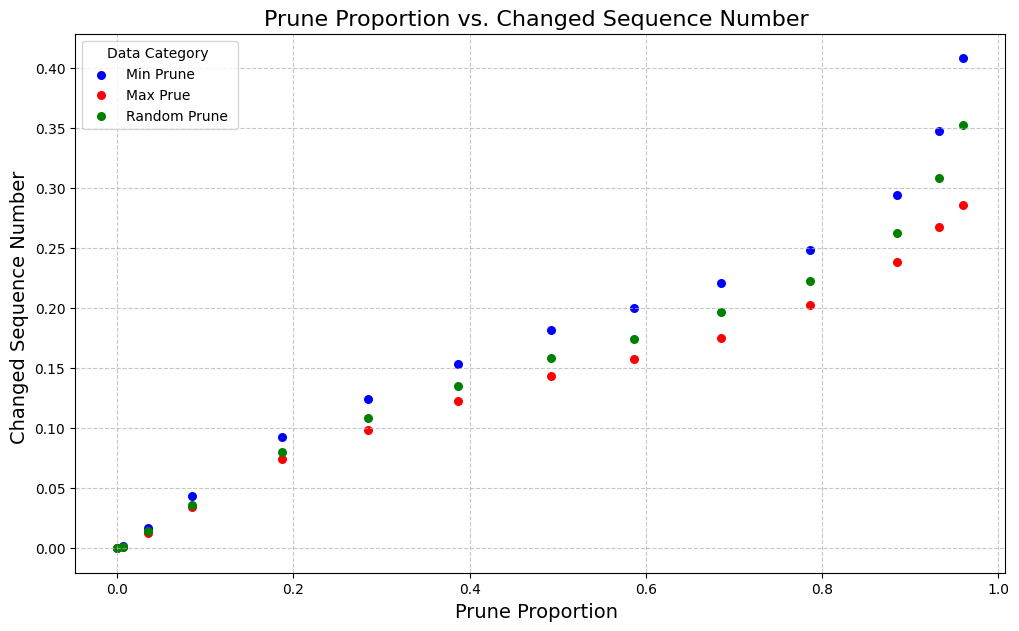

数据已保存到 LossPrunebyseq_Climate.csv


,Prune Proportion Min,Changed Sequence Number Min,Prune Proportion Max,Changed Sequence Number Max,Prune Proportion Random,Changed Sequence Number Random
0,0.000000,0,0.000000,0,0.000000,0
1,0.006787,45,0.006787,34,0.006787,33
2,0.034580,455,0.034580,337,0.034580,378
3,0.085058,1154,0.085058,912,0.085058,973
4,0.186775,2479,0.186775,1990,0.186775,2150
5,0.284832,3330,0.284832,2632,0.284832,2894
6,0.386370,4114,0.386370,3281,0.386370,3613
7,0.492334,4856,0.492334,3849,0.492334,4233
8,0.586452,5366,0.586452,4209,0.586452,4659
9,0.684814,5915,0.684814,4690,0.684814,5276


In [ ]:
plot_pruning_analysis(pruneproportion_min, changed_seqnum_min, pruneproportion_max, changed_seqnum_max, pruneproportion_random, changed_seqnum_random,total_seqnum)
save_to_csv(pruneproportion_min, changed_seqnum_min, pruneproportion_max, changed_seqnum_max, pruneproportion_random, changed_seqnum_random, filename='LossPrunebyseq_Traffic.csv')

## Climate

In [14]:
NUM_COMBINED_SETTINGS = 125
with open('LoadedList_Climate.pkl', 'rb') as f:  # 'rb' 表示二进制读取模式
    loaded_list = pickle.load(f)  # 从文件读取并反序列化#载入数据
final_assignment_list= np.load("Final_assignments_Climate.npy")

models = [SettingPredictorRNN(embedding_dim=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_rnn_layers=NUM_RNN_LAYERS, num_categories=NUM_COMBINED_SETTINGS).to(device) for _ in range(NUM_MAIN_MODELS)]
models[0] = torch.load("model1_Climate.pth",weights_only=False)
models[1] = torch.load("model2_Climate.pth",weights_only=False)   
models[2] = torch.load("model3_Climate.pth",weights_only=False)
Model = torch.load("TotalModel_Climate.pth",weights_only=False)

In [17]:
total_loss_list,setting_loss_list,time_loss_list=LossCalculate(loaded_list,final_assignment_list,Model,models,SETTING_SCALER,TIME_SCALER_PRUNE)#计算损失值
total_seqnum=[len(loaded_list)]*(len(thresholds)+1)

reclassified_seqnum_min=[0]*(len(thresholds)+1)
reclassified_seqnum_max=[0]*(len(thresholds)+1)
reclassified_seqnum_random=[0]*(len(thresholds)+1)

changed_seqnum_min=[0]*(len(thresholds)+1)
changed_seqnum_max=[0]*(len(thresholds)+1)
changed_seqnum_random=[0]*(len(thresholds)+1)

pruneproportion_min=[0]*(len(thresholds)+1)
pruneproportion_max=[0]*(len(thresholds)+1)
pruneproportion_random=[0]*(len(thresholds)+1)

for i,threshold in enumerate(thresholds):
    results=LossPrune(loaded_list,final_assignment_list,models,threshold, total_loss_list,setting_loss_list,time_loss_list,SETTING_SCALER,TIME_SCALER_RECLASSIFY)
    pruneproportion_min[i+1],reclassified_seqnum_min[i+1],changed_seqnum_min[i+1]=results[0]
    pruneproportion_max[i+1],reclassified_seqnum_max[i+1],changed_seqnum_max[i+1]=results[1]
    pruneproportion_random[i+1],reclassified_seqnum_random[i+1],changed_seqnum_random[i+1]=results[2]

unchanged_seqnum_min = [total_num - changed_num  for total_num,changed_num in zip(total_seqnum,changed_seqnum_min)]
unchanged_seqnum_max = [total_num - changed_num  for total_num,changed_num in zip(total_seqnum,changed_seqnum_max)]
unchanged_seqnum_random = [total_num - changed_num  for total_num,changed_num in zip(total_seqnum,changed_seqnum_random)]

共从 145558 个步骤中检测到 4 个最小异常值; 4 个最大异常值; 4 个随机异常值
最小异常值删减比例: 2.7480454526717873e-05 ;类别改变比例 8.449871139465123e-05
最大异常值删减比例: 2.7480454526717873e-05 ;类别改变比例 8.449871139465123e-05
随机异常值删减比例: 2.7480454526717873e-05 ;类别改变比例 8.449871139465123e-05
共从 145558 个步骤中检测到 576 个最小异常值; 576 个最大异常值; 576 个随机异常值
最小异常值删减比例: 0.003957185451847374 ;类别改变比例 0.013055050910473615
最大异常值删减比例: 0.003957185451847374 ;类别改变比例 0.01271705606489501
随机异常值删减比例: 0.003957185451847374 ;类别改变比例 0.012632557353500358
共从 145558 个步骤中检测到 5280 个最小异常值; 5280 个最大异常值; 5280 个随机异常值
最小异常值删减比例: 0.03627419997526759 ;类别改变比例 0.113143774557438
最大异常值删减比例: 0.03627419997526759 ;类别改变比例 0.11263678228907009
随机异常值删减比例: 0.03627419997526759 ;类别改变比例 0.11335502133592462
共从 145558 个步骤中检测到 19656 个最小异常值; 19656 个最大异常值; 19656 个随机异常值
最小异常值删减比例: 0.13503895354429163 ;类别改变比例 0.3237145633529089
最大异常值删减比例: 0.13503895354429163 ;类别改变比例 0.322954074950357
随机异常值删减比例: 0.13503895354429163 ;类别改变比例 0.3237568127086062
共从 145558 个步骤中检测到 32557 个最小异常值; 32557 个最大异常值; 32557 个随机异常值
最小异常

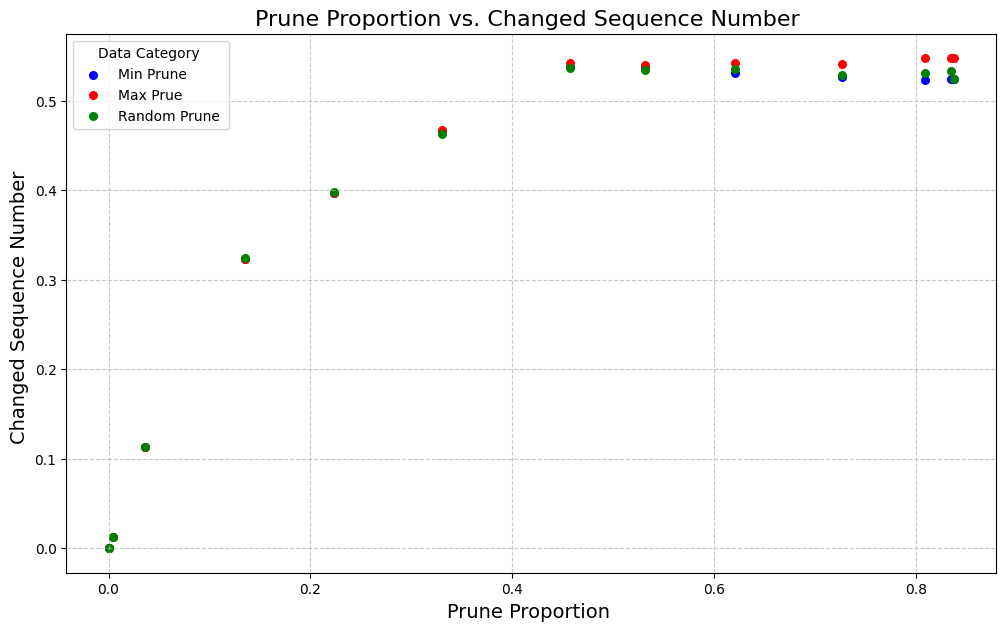

数据已保存到 LossPrunebyseq_Climate.csv


,Prune Proportion Min,Changed Sequence Number Min,Prune Proportion Max,Changed Sequence Number Max,Prune Proportion Random,Changed Sequence Number Random
0,0.000000,0,0.000000,0,0.000000,0
1,0.000027,2,0.000027,2,0.000027,2
2,0.003957,309,0.003957,301,0.003957,299
3,0.036274,2678,0.036274,2666,0.036274,2683
4,0.135039,7662,0.135039,7644,0.135039,7663
5,0.223670,9402,0.223670,9390,0.223670,9413
6,0.330604,11011,0.330604,11065,0.330604,10957
7,0.457309,12721,0.457309,12846,0.457309,12709
8,0.531032,12720,0.531032,12790,0.531032,12640
9,0.620873,12573,0.620873,12827,0.620873,12686


In [18]:
plot_pruning_analysis(pruneproportion_min, changed_seqnum_min, pruneproportion_max, changed_seqnum_max, pruneproportion_random, changed_seqnum_random,total_seqnum)
save_to_csv(pruneproportion_min, changed_seqnum_min, pruneproportion_max, changed_seqnum_max, pruneproportion_random, changed_seqnum_random, filename='LossPrunebyseq_Climate.csv')

## Ticket

In [10]:
NUM_COMBINED_SETTINGS = 13

with open('LoadedList_ticket.pkl', 'rb') as f:  # 'rb' 表示二进制读取模式
    loaded_list = pickle.load(f)  # 从文件读取并反序列化#载入数据
final_assignment_list= np.load("Final_assignments_ticket.npy")

models = [SettingPredictorRNN(embedding_dim=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_rnn_layers=NUM_RNN_LAYERS, num_categories=NUM_COMBINED_SETTINGS).to(device) for _ in range(NUM_MAIN_MODELS)]
models[0] = torch.load("model1_ticket.pth",weights_only=False)
models[1] = torch.load("model2_ticket.pth",weights_only=False)   
models[2] = torch.load("model3_ticket.pth",weights_only=False)
Model = torch.load("TotalModel_ticket.pth",weights_only=False)

In [11]:
total_loss_list,setting_loss_list,time_loss_list=LossCalculate(loaded_list,final_assignment_list,Model,models,SETTING_SCALER,TIME_SCALER_PRUNE)#计算损失值
total_seqnum=[len(loaded_list)]*(len(thresholds)+1)

reclassified_seqnum_min=[0]*(len(thresholds)+1)
reclassified_seqnum_max=[0]*(len(thresholds)+1)
reclassified_seqnum_random=[0]*(len(thresholds)+1)

changed_seqnum_min=[0]*(len(thresholds)+1)
changed_seqnum_max=[0]*(len(thresholds)+1)
changed_seqnum_random=[0]*(len(thresholds)+1)

pruneproportion_min=[0]*(len(thresholds)+1)
pruneproportion_max=[0]*(len(thresholds)+1)
pruneproportion_random=[0]*(len(thresholds)+1)

for i,threshold in enumerate(thresholds):
    results=LossPrune(loaded_list,final_assignment_list,models,threshold, total_loss_list,setting_loss_list,time_loss_list,SETTING_SCALER,TIME_SCALER_RECLASSIFY)
    pruneproportion_min[i+1],reclassified_seqnum_min[i+1],changed_seqnum_min[i+1]=results[0]
    pruneproportion_max[i+1],reclassified_seqnum_max[i+1],changed_seqnum_max[i+1]=results[1]
    pruneproportion_random[i+1],reclassified_seqnum_random[i+1],changed_seqnum_random[i+1]=results[2]

unchanged_seqnum_min = [total_num - changed_num  for total_num,changed_num in zip(total_seqnum,changed_seqnum_min)]
unchanged_seqnum_max = [total_num - changed_num  for total_num,changed_num in zip(total_seqnum,changed_seqnum_max)]
unchanged_seqnum_random = [total_num - changed_num  for total_num,changed_num in zip(total_seqnum,changed_seqnum_random)]

共从 216756 个步骤中检测到 53 个最小异常值; 53 个最大异常值; 53 个随机异常值
最小异常值删减比例: 0.00024451456937754894 ;类别改变比例 0.0
最大异常值删减比例: 0.00024451456937754894 ;类别改变比例 3.192644147883277e-05
随机异常值删减比例: 0.00024451456937754894 ;类别改变比例 3.192644147883277e-05
共从 216756 个步骤中检测到 2148 个最小异常值; 2148 个最大异常值; 2148 个随机异常值
最小异常值删减比例: 0.00990976028345236 ;类别改变比例 0.0011812783347168124
最大异常值删减比例: 0.00990976028345236 ;类别改变比例 0.002394483110912458
随机异常值删减比例: 0.00990976028345236 ;类别改变比例 0.0020432922546452974
共从 216756 个步骤中检测到 10369 个最小异常值; 10369 个最大异常值; 10369 个随机异常值
最小异常值删减比例: 0.04783719943161897 ;类别改变比例 0.013919928484771088
最大异常值删减比例: 0.04783719943161897 ;类别改变比例 0.025030330119404892
随机异常值删减比例: 0.04783719943161897 ;类别改变比例 0.017272204840048527
共从 216756 个步骤中检测到 29784 个最小异常值; 29784 个最大异常值; 29784 个随机异常值
最小异常值删减比例: 0.13740796102530034 ;类别改变比例 0.06509801417534002
最大异常值删减比例: 0.13740796102530034 ;类别改变比例 0.08332801225975353
随机异常值删减比例: 0.13740796102530034 ;类别改变比例 0.0661515867441415
共从 216756 个步骤中检测到 47387 个最小异常值; 47387 个最大异常值; 47387 个随机异常值
最小异常值

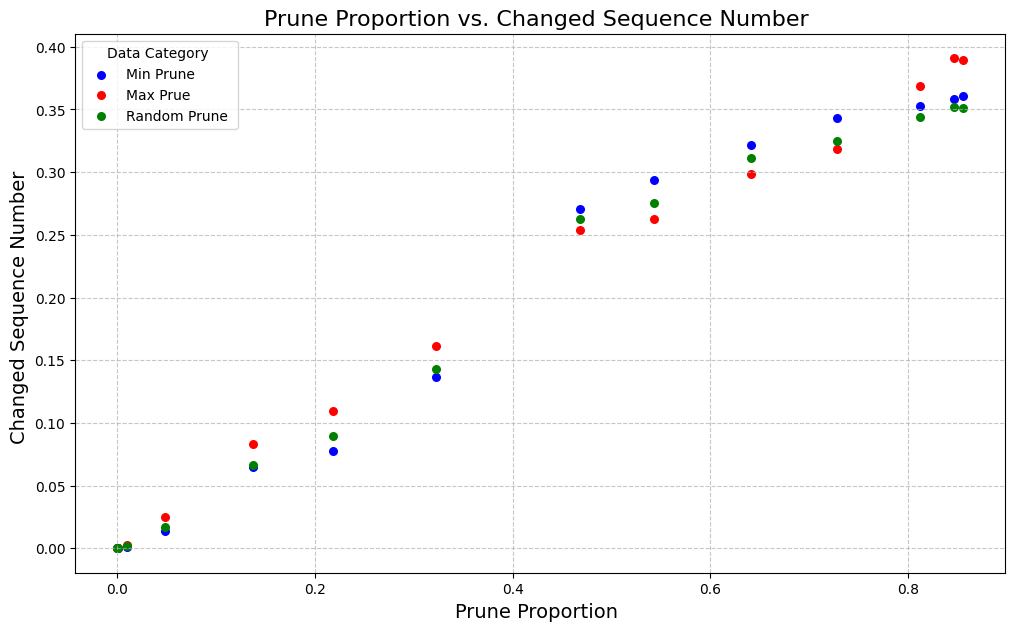

数据已保存到 LossPrunebyseq_Ticket.csv


,Prune Proportion Min,Changed Sequence Number Min,Prune Proportion Max,Changed Sequence Number Max,Prune Proportion Random,Changed Sequence Number Random
0,0.000000,0,0.000000,0,0.000000,0
1,0.000245,0,0.000245,1,0.000245,1
2,0.009910,37,0.009910,75,0.009910,64
3,0.047837,436,0.047837,784,0.047837,541
4,0.137408,2039,0.137408,2610,0.137408,2072
5,0.218619,2417,0.218619,3429,0.218619,2809
6,0.322399,4275,0.322399,5043,0.322399,4470
7,0.468490,8476,0.468490,7954,0.468490,8231
8,0.542795,9199,0.542795,8231,0.542795,8617
9,0.641186,10081,0.641186,9342,0.641186,9745


In [12]:
plot_pruning_analysis(pruneproportion_min, changed_seqnum_min, pruneproportion_max, changed_seqnum_max, pruneproportion_random, changed_seqnum_random,total_seqnum)
save_to_csv(pruneproportion_min, changed_seqnum_min, pruneproportion_max, changed_seqnum_max, pruneproportion_random, changed_seqnum_random, filename='LossPrunebyseq_Ticket.csv')